In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

df = pd.read_csv('Google-Playstore.csv')
df.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,...,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,...,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,...,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-an...,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UC...,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,...,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,NaN,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,...,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


I. Data cleaning \
The data was originally scraped from Google Playstore and was still in raw format. First and foremost, we need to clean the data before proceeding to perform EDA. There are unnecessary columns for our model such as App Id, App Name, Developer Id, Developer Website, Developer Email, Privacy Policy, Scraped Time, Released and Last Updated. So, we'll remove them from the dataset. Also, there are 3 Installs columns in the dataset, only the Maximum Installs is the actual count of installs, so we'll keep this column, rename it and remove the other two.

In [2]:
cleaned_df = df.drop(columns=["App Id", "Minimum Android", "Developer Id", "Developer Website", "Developer Email", "Installs", "Minimum Installs", "Privacy Policy", "Scraped Time", "App Name", "Released", "Last Updated"])
cleaned_df.rename(columns = {'Maximum Installs':'Installs'}, inplace=True)
cleaned_df.head()

,Category,Rating,Rating Count,Installs,Free,Price,Currency,Size,Content Rating,Ad Supported,In App Purchases,Editors Choice
0,Adventure,0.0,0.0,15,True,0.0,USD,10M,Everyone,False,False,False
1,Tools,4.4,64.0,7662,True,0.0,USD,2.9M,Everyone,True,False,False
2,Productivity,0.0,0.0,58,True,0.0,USD,3.7M,Everyone,False,False,False
3,Communication,5.0,5.0,19,True,0.0,USD,1.8M,Everyone,True,False,False
4,Tools,0.0,0.0,478,True,0.0,USD,6.2M,Everyone,False,False,False


The size column is in str format since there are letters M, G, k in the value. So we fix it:

In [3]:
def clean_size(x):
  x = str(x).replace(',', '')
  if 'M' in x:
    x = float(x.strip('M'))
    x *= 1024
  elif 'G' in x:
    x = float(x.strip('G'))
    x *= 1024 * 1024
  elif 'k' in x:
    x = float(x.strip('k'))
  else:
    x = 'NA'
  return x
cleaned_df['Size'] = cleaned_df['Size'].map(clean_size)
cleaned_df[cleaned_df['Size'] == 'NA'].shape

(74973, 12)

There are 74973 rows with missing values from the Size feature, which accounts for only 74973 / 2312944 * 100 = 3.24% total rows. So, we'll simply drop those rows since we don't have enough features that can help represents the size of the app using other ML techniques.

In [4]:
cleaned_df = cleaned_df[cleaned_df['Size'] != 'NA']
cleaned_df['Size'] = pd.to_numeric(cleaned_df['Size'])

In [5]:
cleaned_df.isnull().sum()

Category              0
Rating              958
Rating Count        958
Installs              0
Free                  0
Price                 0
Currency             63
Size                  0
Content Rating        0
Ad Supported          0
In App Purchases      0
Editors Choice        0
dtype: int64

The total number of rows with null values in the Rating, Rating Count, and Currency columns is very small compared to the size of the dataset. So, we can safely drop those rows.

In [6]:
cleaned_df.dropna(inplace=True)

In [7]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2236994 entries, 0 to 2312943
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Category          object 
 1   Rating            float64
 2   Rating Count      float64
 3   Installs          int64  
 4   Free              bool   
 5   Price             float64
 6   Currency          object 
 7   Size              float64
 8   Content Rating    object 
 9   Ad Supported      bool   
 10  In App Purchases  bool   
 11  Editors Choice    bool   
dtypes: bool(4), float64(4), int64(1), object(3)
memory usage: 162.1+ MB


Convert data types of some columns to the appropriate date type:

In [8]:
cleaned_df['Rating Count'] = cleaned_df['Rating Count'].astype('int64')
cleaned_df['Category'] = cleaned_df['Category'].astype(str)
cleaned_df['Currency'] = cleaned_df['Currency'].astype(str)
cleaned_df['Content Rating'] = cleaned_df['Content Rating'].astype(str)

In [9]:
cleaned_df["Category"].value_counts()

Education                  234693
Music & Audio              152820
Business                   138964
Tools                      138622
Entertainment              134855
Lifestyle                  115707
Books & Reference          114900
Personalization             87947
Health & Fitness            81082
Productivity                76013
Shopping                    73737
Food & Drink                72501
Travel & Local              65126
Finance                     63046
Arcade                      51113
Puzzle                      47908
Casual                      47395
Communication               46459
Sports                      45566
Social                      43223
News & Magazines            40977
Photography                 34799
Medical                     30806
Maps & Navigation           25592
Action                      25538
Adventure                   21925
Simulation                  21697
Educational                 20202
Art & Design                18196
Auto & Vehicle

There are repeated categories such as 'Music' and 'Music & Audio', 'Education' and 'Educational'. So we will merge them into one single category for better data representation.

In [10]:
cleaned_df['Category'].replace('Music & Audio', 'Music', inplace=True)
cleaned_df['Category'].replace('Educational', 'Education', inplace=True)

In [11]:
cleaned_df['Content Rating'].value_counts()

Everyone           1958281
Teen                188426
Mature 17+           58370
Everyone 10+         31633
Unrated                151
Adults only 18+        133
Name: Content Rating, dtype: int64

Notice that Everyone +10 label is subset of Teen label and Adults only 18+ label is subset of Mature 17+ label. So we merge them accordingly for better data representation. 

In [12]:
cleaned_df['Content Rating'].replace('Everyone 10+', 'Teen', inplace=True)
cleaned_df['Content Rating'].replace('Adults only 18+', 'Mature 17+', inplace=True)

In [13]:
cleaned_df["Currency"].value_counts()

USD    2235760
XXX       1211
EUR          6
INR          5
GBP          3
CAD          2
VND          1
ZAR          1
AUD          1
KRW          1
BRL          1
SGD          1
TRY          1
Name: Currency, dtype: int64

XXX stands for unknown currency transaction. The default price is in USD. Since the total number of apps that use anything other than USD is less than 0.1% of the size of the dataset, we can safely drop these apps without the need of doing currency coversion. After doing this, the currency column becomes redundant, we proceed to drop this column from our cleaned data.

In [14]:
cleaned_df.drop(cleaned_df.index[cleaned_df.Currency != 'USD'], inplace=True)
cleaned_df.drop(columns = 'Currency', inplace=True)

In [15]:
print(cleaned_df[cleaned_df['Price'] == 0].shape)
print(cleaned_df[cleaned_df['Free'] == True].shape)
print((cleaned_df[cleaned_df['Free'] == True].shape[0] / cleaned_df.shape[0]) * 100)

(2193228, 11)
(2193228, 11)
98.09764912155151


We see that 98% percent of the apps exist in the app store are Free. In that case, the app developers will make profit based on their ads revenue as well as in app purchases. This is the most favorite business model as most users will prefer their apps to be free. So, the Free feature will be included to predict our target variable.  Any apps with Price = 0.0 will have the variable Free set to True. Thus, we will get rid of the Price column since we already kept the Free column.

In [16]:
cleaned_df.drop(columns = 'Price', inplace=True)

In [17]:
dup = cleaned_df[cleaned_df.duplicated()]
dup.shape[0] / cleaned_df.shape[0] * 100

12.233558163666942

At this point, the cleaned dataset have about 12.2% of duplicated rows out of the whole dataset. Those duplicates exist because we didn't include the identifier columns App Id and App Name since the model won't need them. Now, our question are where are those duplicates from and should we keep them? Let's inspect further.

In [18]:
print(dup['Rating'].value_counts(normalize=True))
print(dup['Rating Count'].value_counts(normalize=True))

0.0    0.998351
5.0    0.001393
4.9    0.000062
4.8    0.000048
4.2    0.000033
4.7    0.000029
4.3    0.000026
4.6    0.000018
4.0    0.000015
4.5    0.000007
4.4    0.000007
1.7    0.000004
3.8    0.000004
3.9    0.000004
Name: Rating, dtype: float64
0     0.998351
5     0.000728
6     0.000428
7     0.000179
8     0.000091
9     0.000051
10    0.000048
11    0.000040
12    0.000022
17    0.000011
27    0.000007
16    0.000007
21    0.000007
22    0.000004
26    0.000004
23    0.000004
14    0.000004
20    0.000004
19    0.000004
13    0.000004
29    0.000004
Name: Rating Count, dtype: float64


It turns out that 99% of the duplicated rows came from the unrated apps. These are apps that have very few users, so they will share common features such as having no rating, rating count, and low installs. These duplicates came with this particular dataset, so they are not likely due to data collection error. Whether to keep the duplicates or not will depend on the goal of our model. As we want our model to be more roburst and flexible in its prediction, we decided to drop those duplicates so the model won't "memorize" the dataset when making new prediction.

In [19]:
cleaned_df.drop_duplicates(keep='first', inplace=True)

Now we'll add the target variable Popularity for our data modeling in part III. The Popularity is a binary variable, its value can either be 'Likely' or 'Unlikely'. The Popularity is determined based on the value of the Score variable. The Score is calculated based on favorable features that we've decided on. More details are provided in our report.

In [20]:
cleaned_df['Score'] = 0
cleaned_df["Popularity"] = "Unlikely" 

# Popularity Score
cleaned_df['Popularity'].astype(str)
cleaned_df.loc[cleaned_df['Rating'] >=2.5, 'Score'] += 1
cleaned_df.loc[cleaned_df['Rating Count'] >= cleaned_df['Rating Count'].median(), 'Score'] += 1
cleaned_df.loc[cleaned_df['Installs'] >= cleaned_df['Installs'].median(), 'Score'] += 1
cleaned_df.loc[cleaned_df['Free'] == True, 'Score'] += 1
cleaned_df.loc[cleaned_df['Size'] <= cleaned_df['Size'].median(), 'Score'] += 1
cleaned_df.loc[cleaned_df['Ad Supported'] == False, 'Score'] += 1
cleaned_df.loc[cleaned_df['Editors Choice'] == True, 'Score'] += 1
cleaned_df.loc[cleaned_df['Score'] > 3 , 'Popularity'] = 'Likely'
cleaned_df.head()

,Category,Rating,Rating Count,Installs,Free,Size,Content Rating,Ad Supported,In App Purchases,Editors Choice,Score,Popularity
0,Adventure,0.0,0,15,True,10240.0,Everyone,False,False,False,3,Unlikely
1,Tools,4.4,64,7662,True,2969.6,Everyone,True,False,False,5,Likely
2,Productivity,0.0,0,58,True,3788.8,Everyone,False,False,False,3,Unlikely
3,Communication,5.0,5,19,True,1843.2,Everyone,True,False,False,3,Unlikely
4,Tools,0.0,0,478,True,6348.8,Everyone,False,False,False,3,Unlikely


II. Data Visualization

In [21]:
cleaned_df.groupby('Content Rating')['Installs'].mean()

Content Rating
Everyone      185948.264610
Mature 17+    280572.910109
Teen          495801.512015
Unrated        40942.086093
Name: Installs, dtype: float64

In [22]:
cleaned_df.groupby('Editors Choice')['Installs'].mean()

Editors Choice
False    2.070321e+05
True     3.792961e+07
Name: Installs, dtype: float64

In [23]:
cleaned_df.groupby('Editors Choice')['Rating'].mean()

Editors Choice
False    2.486941
True     4.332429
Name: Rating, dtype: float64

Text(0.5, 1.0, 'Histogram of App Rating')

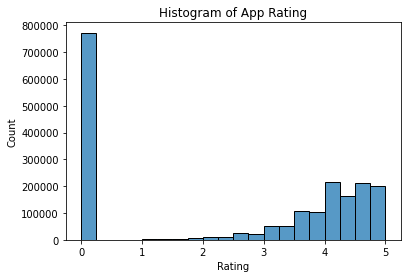

In [24]:
sns.histplot(data=cleaned_df, x='Rating', bins = 20)
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.title('Histogram of App Rating')

Text(0.5, 1.0, 'Histogram of App Rating > 0')

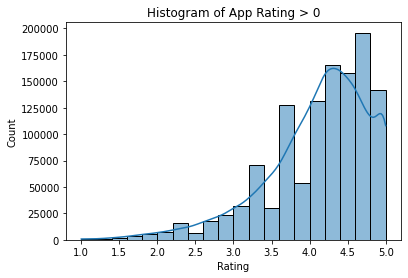

In [25]:
sns.histplot(data=cleaned_df[cleaned_df['Rating'] > 0], x='Rating', bins = 20, kde = True, kde_kws = {'bw_adjust':2.3})
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.title('Histogram of App Rating > 0')

<AxesSubplot:xlabel='Free', ylabel='count'>

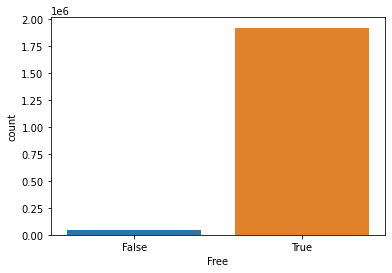

In [26]:
sns.countplot(data=cleaned_df, x='Free')

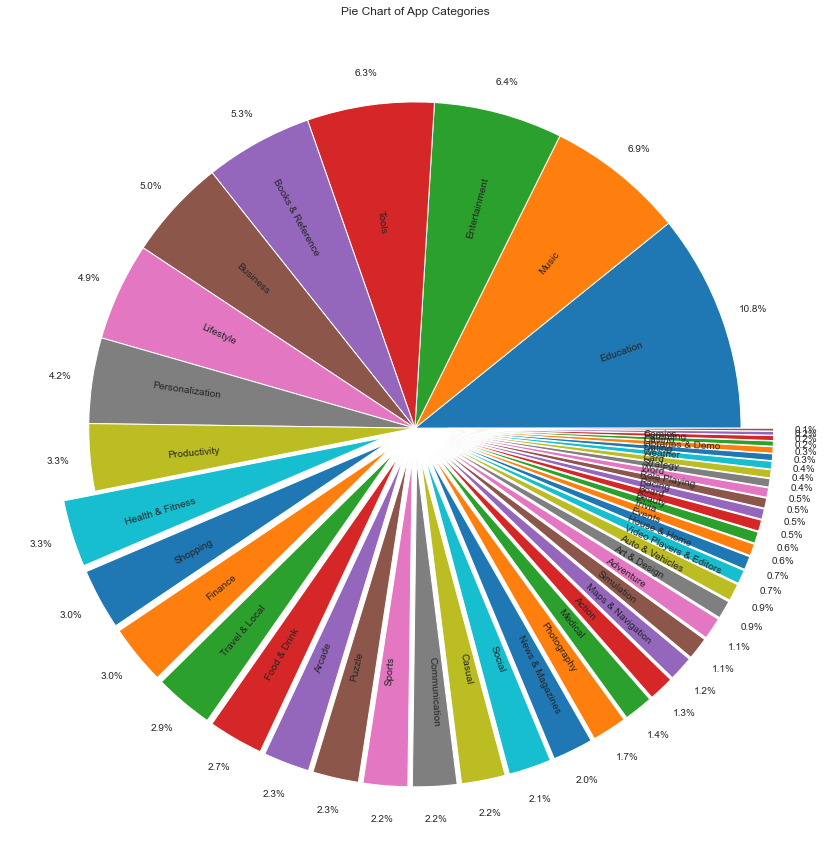

In [27]:
rcParams['figure.figsize'] = 20, 15
sns.set_style('darkgrid')
category_labels = cleaned_df['Category'].value_counts().index
explode = []
for i in range(len(cleaned_df['Category'].value_counts().index)):
  if i > 8:
    explode.append(0.1)
  else:
    explode.append(0)

plt.pie(cleaned_df['Category'].value_counts().values, labels=category_labels, rotatelabels=True, labeldistance=0.6, autopct='%1.1f%%', explode=explode, pctdistance=1.1)
plt.title("Pie Chart of App Categories")
plt.show()

Text(0.5, 1.0, 'Histogram of Content Rating')

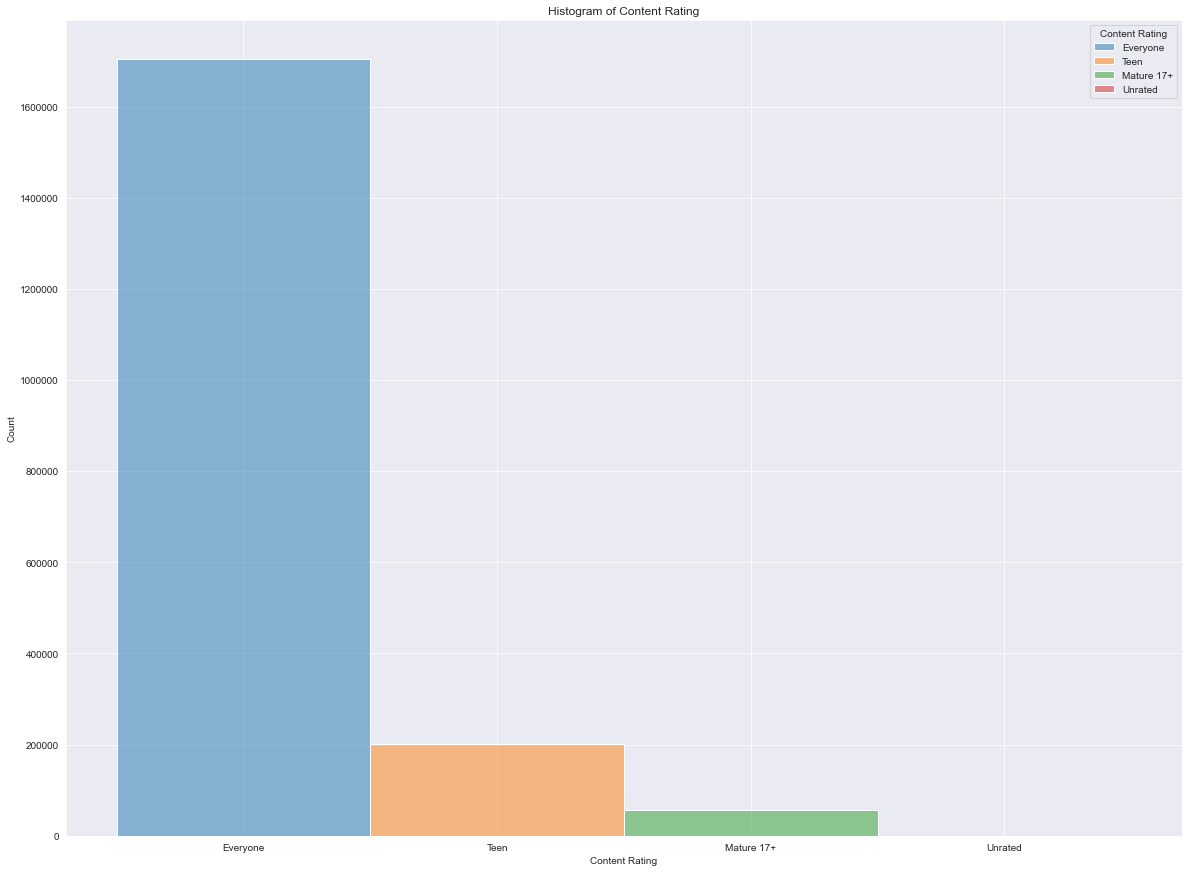

In [28]:
sns.histplot(data=cleaned_df, x='Content Rating', hue='Content Rating')
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
plt.title('Histogram of Content Rating')

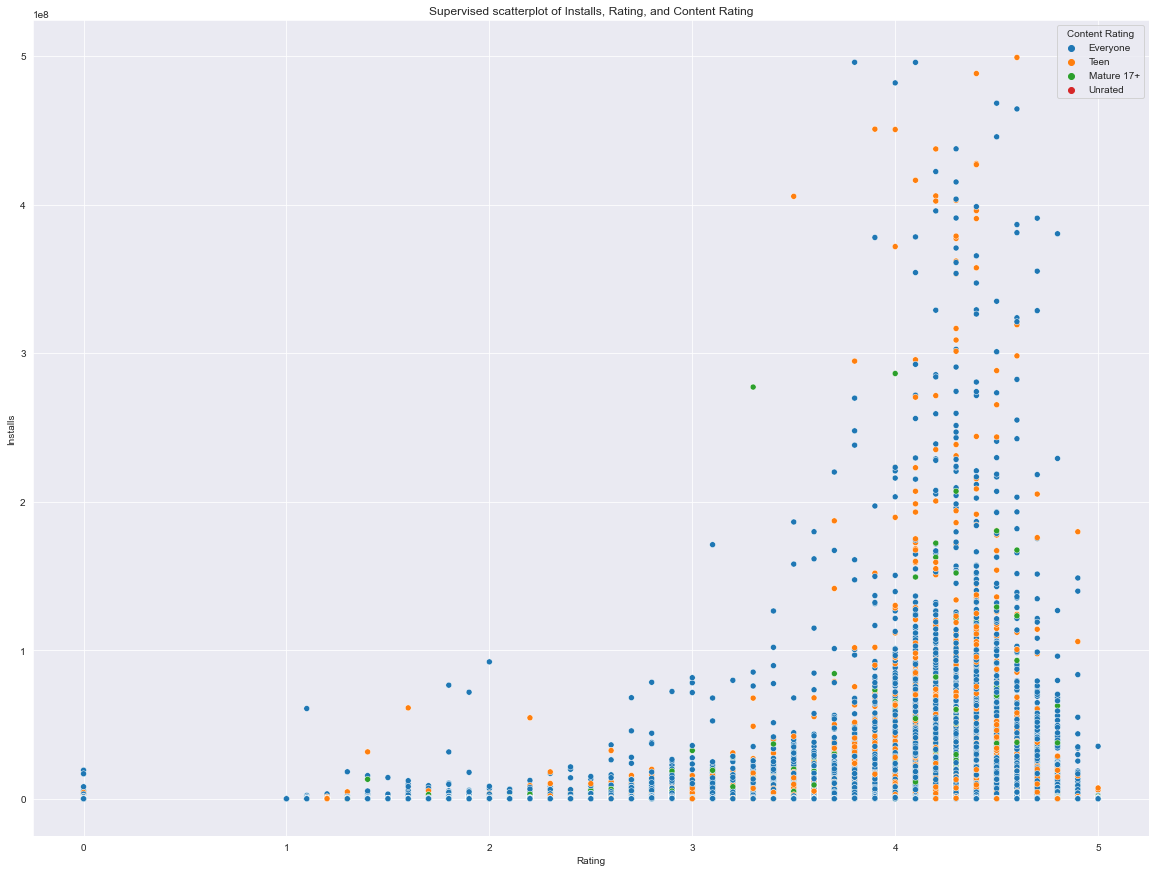

In [64]:
plt.title('Supervised scatterplot of Installs, Rating, and Content Rating')
sns.scatterplot(data=cleaned_df[cleaned_df['Installs'] <= 500000000], y='Installs', x='Rating', hue='Content Rating')
plt.ticklabel_format(style='plain', axis='x', useOffset=False)

<AxesSubplot:>

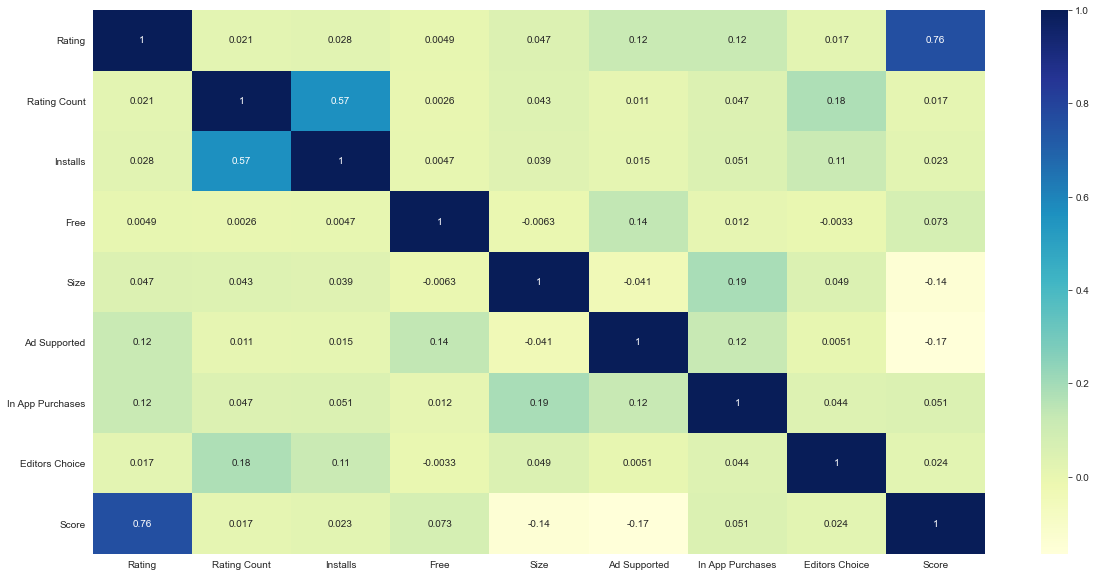

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
sns.heatmap(cleaned_df.corr(), annot=True, cmap='YlGnBu')

III. Data Modeling

In [31]:
# encoding and making zip file
le = preprocessing.LabelEncoder()

category_encode = le.fit_transform(cleaned_df['Category'])
content_encode = le.fit_transform(cleaned_df['Content Rating'])
editor_encode = le.fit_transform(cleaned_df['Editors Choice'])
Ad_endcode = le.fit_transform(cleaned_df['Ad Supported'])
purchase_encode = le.fit_transform(cleaned_df['In App Purchases'])
free_encode = le.fit_transform(cleaned_df['Free'])

target = le.fit_transform(cleaned_df['Popularity'])

features=list(zip(category_encode,cleaned_df['Rating'], cleaned_df['Rating Count'], cleaned_df['Installs'],free_encode, cleaned_df['Size'], content_encode, Ad_endcode, purchase_encode, editor_encode, cleaned_df['Score']))

In [32]:
# train test split with 70, 30 ratio.
X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.3, random_state=42)

In [33]:
#knn model
#find best k
test_scores = []
train_scores = []
K = [1, 3, 5, 7, 9, 11, 15, 101, 111]
for k in K:

    knn = KNeighborsClassifier(k)

    print("Fitting with k value of {}".format(i), end="\r")
    knn.fit(X_train,y_train)

    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

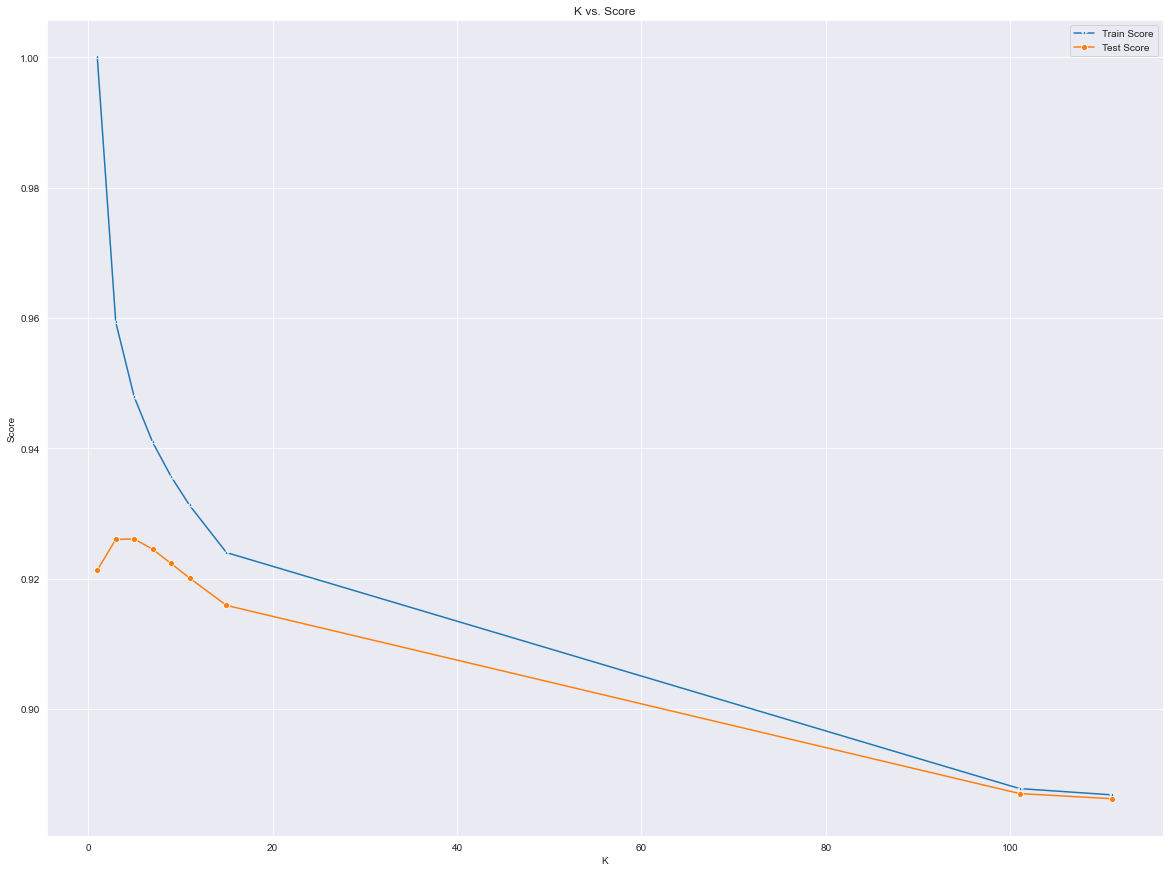

In [34]:
sns.lineplot(x=K, y=train_scores, marker='*', label='Train Score')
sns.lineplot(x=K, y=test_scores, marker='o', label='Test Score')
plt.title('K vs. Score')
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

In [37]:
knn = KNeighborsClassifier(K[test_scores.index(max(test_scores))])
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

In [38]:
print("Accuracy:",metrics.accuracy_score(y_pred,y_test))

Accuracy: 0.9260984414150423


In [39]:
le = preprocessing.LabelEncoder()

rfc_features=list(zip(category_encode,cleaned_df['Rating'], cleaned_df['Rating Count'], cleaned_df['Installs'],free_encode, cleaned_df['Size'], content_encode, Ad_endcode, purchase_encode, editor_encode))

In [54]:
# Random Forest model
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(rfc_features)
X_scaled = pd.DataFrame(data=X_scaled, columns=cleaned_df.drop(['Score', 'Popularity'], axis=1).columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,target,test_size=0.3, random_state=42)


RFC = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
RFC.fit(X_train, y_train)
RFC_pred = RFC.predict(X_test)

In [61]:
print("Accuracy:",metrics.accuracy_score(y_test , RFC_pred))

Accuracy: 0.9452295409181637


In [62]:
importances = RFC.feature_importances_
importances = pd.DataFrame(importances, index=X_train.columns, columns=['Values'])

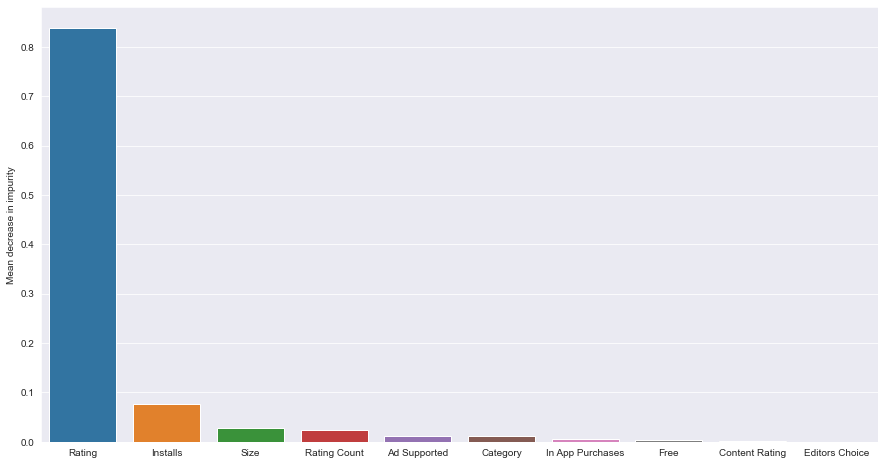

In [63]:
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(y=importances['Values'], x=importances.index, order=importances.sort_values(by='Values', ascending=False).index, ax=ax)
ax.set_ylabel('Mean decrease in impurity')

plt.show()


In [65]:
# MLP model
X = features
Y = target

scaler = StandardScaler()
X_scaled=scaler.fit_transform(X)
X = pd.DataFrame(data=X_scaled, columns=cleaned_df.drop(['Popularity'], axis=1).columns)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state= 42)

In [66]:
parameters = {'activation' : ['relu'], 'solver' :['lbfgs', 'sgd', 'adam'], 'alpha' :[0.01, 0.001, 1], 'learning_rate' : ['adaptive'], 'max_iter' : [25, 50, 100], 'hidden_layer_sizes' : [64, 32, 16], 'random_state' : [42]}

In [68]:
mlp = MLPClassifier()
search = GridSearchCV(estimator=mlp, param_grid=parameters, verbose = 10, refit=True, n_jobs = 1)
search.fit(x_train, y_train)

print('Best Parameters:', search.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5; 1/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=lbfgs
[CV 1/5; 1/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=lbfgs;, score=1.000 total time=  24.2s
[CV 2/5; 1/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=lbfgs
[CV 2/5; 1/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=lbfgs;, score=1.000 total time=  24.4s
[CV 3/5; 1/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=lbfgs
[CV 3/5; 1/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=lbfgs;, score=1.000 total time=  24.9s
[CV 4

C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 2/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time= 1.7min
[CV 2/5; 2/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 2/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time= 1.6min
[CV 3/5; 2/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 2/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time= 1.5min
[CV 4/5; 2/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 2/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time= 1.5min
[CV 5/5; 2/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 2/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time= 1.6min
[CV 1/5; 3/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 1/5; 3/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam;, score=1.000 total time=  50.2s
[CV 2/5; 3/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 2/5; 3/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam;, score=1.000 total time=  49.9s
[CV 3/5; 3/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 3/5; 3/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, lea

C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 5/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 3.1min
[CV 2/5; 5/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 5/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 3.1min
[CV 3/5; 5/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 5/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 3.2min
[CV 4/5; 5/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 5/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 3.1min
[CV 5/5; 5/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 5/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 3.2min
[CV 1/5; 6/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam
[CV 1/5; 6/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam;, score=1.000 total time=  51.2s
[CV 2/5; 6/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam
[CV 2/5; 6/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam;, score=1.000 total time=  46.9s
[CV 3/5; 6/81] START activation=relu, alpha=0.01, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam
[CV 3/5; 6/81] END activation=relu, alpha=0.01, hidden_layer_sizes=64, lea

C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 11/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  44.2s
[CV 2/5; 11/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 11/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  44.8s
[CV 3/5; 11/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 11/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  46.8s
[CV 4/5; 11/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 11/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  42.9s
[CV 5/5; 11/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 11/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  47.0s
[CV 1/5; 12/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 1/5; 12/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam;, score=1.000 total time=  26.5s
[CV 2/5; 12/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 2/5; 12/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam;, score=1.000 total time=  26.3s
[CV 3/5; 12/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 3/5; 12/81] END activation=relu, alpha=0.01, hidden_layer_sizes=

C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 14/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 1.6min
[CV 2/5; 14/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 14/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 1.5min
[CV 3/5; 14/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 14/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 1.4min
[CV 4/5; 14/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 14/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 1.4min
[CV 5/5; 14/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 14/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 1.5min
[CV 1/5; 15/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam
[CV 1/5; 15/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam;, score=1.000 total time=  26.1s
[CV 2/5; 15/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam
[CV 2/5; 15/81] END activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam;, score=1.000 total time=  26.3s
[CV 3/5; 15/81] START activation=relu, alpha=0.01, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam
[CV 3/5; 15/81] END activation=relu, alpha=0.01, hidden_layer_sizes=

C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 20/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  40.2s
[CV 2/5; 20/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 20/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  39.1s
[CV 3/5; 20/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 20/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  39.5s
[CV 4/5; 20/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 20/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  40.5s
[CV 5/5; 20/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 20/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  39.5s
[CV 1/5; 21/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 1/5; 21/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam;, score=1.000 total time=  19.7s
[CV 2/5; 21/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 2/5; 21/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam;, score=1.000 total time=  21.9s
[CV 3/5; 21/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 3/5; 21/81] END activation=relu, alpha=0.01, hidden_layer_sizes=

C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 23/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 1.4min
[CV 2/5; 23/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 23/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 1.4min
[CV 3/5; 23/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 23/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 1.4min
[CV 4/5; 23/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 23/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 1.3min
[CV 5/5; 23/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 23/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 1.3min
[CV 1/5; 24/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam
[CV 1/5; 24/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam;, score=1.000 total time=  22.6s
[CV 2/5; 24/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam
[CV 2/5; 24/81] END activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam;, score=1.000 total time=  22.7s
[CV 3/5; 24/81] START activation=relu, alpha=0.01, hidden_layer_sizes=16, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam
[CV 3/5; 24/81] END activation=relu, alpha=0.01, hidden_layer_sizes=

C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 29/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time= 1.5min
[CV 2/5; 29/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 29/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time= 1.6min
[CV 3/5; 29/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 29/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time= 1.7min
[CV 4/5; 29/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 29/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time= 1.7min
[CV 5/5; 29/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 29/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time= 1.6min
[CV 1/5; 30/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 1/5; 30/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam;, score=1.000 total time=  46.6s
[CV 2/5; 30/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 2/5; 30/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam;, score=1.000 total time=  48.8s
[CV 3/5; 30/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 3/5; 30/81] END activation=relu, alpha=0.001, hidden_layer

C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 32/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 3.2min
[CV 2/5; 32/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 32/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 3.1min
[CV 3/5; 32/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 32/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 3.2min
[CV 4/5; 32/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 32/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 4.1min
[CV 5/5; 32/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 32/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=sgd;, score=1.000 total time= 4.1min
[CV 1/5; 33/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam
[CV 1/5; 33/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam;, score=1.000 total time= 1.1min
[CV 2/5; 33/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam
[CV 2/5; 33/81] END activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam;, score=1.000 total time= 1.1min
[CV 3/5; 33/81] START activation=relu, alpha=0.001, hidden_layer_sizes=64, learning_rate=adaptive, max_iter=50, random_state=42, solver=adam
[CV 3/5; 33/81] END activation=relu, alpha=0.001, hidden_layer

C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5; 38/81] END activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  56.0s
[CV 2/5; 38/81] START activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5; 38/81] END activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  57.7s
[CV 3/5; 38/81] START activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5; 38/81] END activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  56.7s
[CV 4/5; 38/81] START activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5; 38/81] END activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  56.7s
[CV 5/5; 38/81] START activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd


C:\Users\nnath\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5; 38/81] END activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=sgd;, score=1.000 total time=  55.5s
[CV 1/5; 39/81] START activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 1/5; 39/81] END activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam;, score=1.000 total time=  30.8s
[CV 2/5; 39/81] START activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 2/5; 39/81] END activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam;, score=1.000 total time=  33.2s
[CV 3/5; 39/81] START activation=relu, alpha=0.001, hidden_layer_sizes=32, learning_rate=adaptive, max_iter=25, random_state=42, solver=adam
[CV 3/5; 39/81] END activation=relu, alpha=0.001, hidden_layer

KeyboardInterrupt: 

In [ ]:
mlp = MLPClassifier(activation='relu', alpha=0.01, hidden_layer_sizes=64, learning_rate='adaptive', max_iter=3000, random_state=42, solver='lbfgs')
mlp.fit(x_train, y_train)
pred = mlp.predict(x_test)

In [ ]:
print()
print('Accuracy Score : ' + str(metrics.accuracy_score(y_test,pred)))
print()
print(confusion_matrix(y_test,pred))
print()
print(classification_report(y_test,pred))
